In [1]:
from disk_utils_jax import jax_model, jax_model_scal
from regression import log_likelihood, log_likelihood_1d
from SLD_ojax import ScatteredLightDisk
from SLD_utils import *
import jax.numpy as jnp
import matplotlib.pyplot as plt
from datetime import datetime
from jax import jit
import numpy as np

## Defining Disk and SPF Parameters

In [2]:
disk_params1 = {}
disk_params1['inclination'] = 60. #In degrees
disk_params1['position_angle'] = 50. #In Degrees
disk_params1['alpha_in'] = 8. #The inner power law
disk_params1['alpha_out'] = -5. #The outer power law
#gs_ws = jnp.array([0.8,-0.2,0,0.75,0.25,0.]) #Here we have 3 Henyey-Greenstein functions with g parameters of 1, -1, and 0. The weights are 0.75, 0.25, and 0 respectively. 
disk_params1['flux_scaling'] = 1e6

#The disk size
disk_params1['sma'] = 30. #This is the semi-major axis of the model in astronomical units. 
#To get this in pixels, divide by the distance to the star, to get it in arcseconds. To get it in pixeks, divide by the pixel scale.

In [3]:
disk_params2 = {}
disk_params2['inclination'] = 40. #In degrees
disk_params2['position_angle'] = 30. #In Degrees
disk_params2['alpha_in'] = 5. #The inner power law
disk_params2['alpha_out'] = -7. #The outer power law
#gs_ws = jnp.array([0.8,-0.2,0,0.75,0.25,0.]) #Here we have 3 Henyey-Greenstein functions with g parameters of 1, -1, and 0. The weights are 0.75, 0.25, and 0 respectively. 
disk_params2['flux_scaling'] = 1e6

#The disk size
disk_params2['sma'] = 40. #This is the semi-major axis of the model in astronomical units. 
#To get this in pixels, divide by the distance to the star, to get it in arcseconds. To get it in pixeks, divide by the pixel scale.

In [4]:
# Scattering Phase Function Parameters
spf_params={'g1': 0.5, 'g2': -0.3, 'weight': 0.7}

## Creating Disk Models

In [5]:
# Disk 1
start = datetime.now()
disk_image1 = jax_model(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_params=disk_params1,
                              spf_params={'g1': 0.9, 'g2': -0.2, 'weight': 0.7})
end = datetime.now()
print(end-start)

# Disk 2
start = datetime.now()
disk_image2 = jax_model(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_params=disk_params2,
                               spf_params={'g1': 0.5, 'g2': -0.3, 'weight': 0.7})
end = datetime.now()
print(end-start)

2024-06-03 22:55:11.577500: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


0:00:04.131642
0:00:00.000684


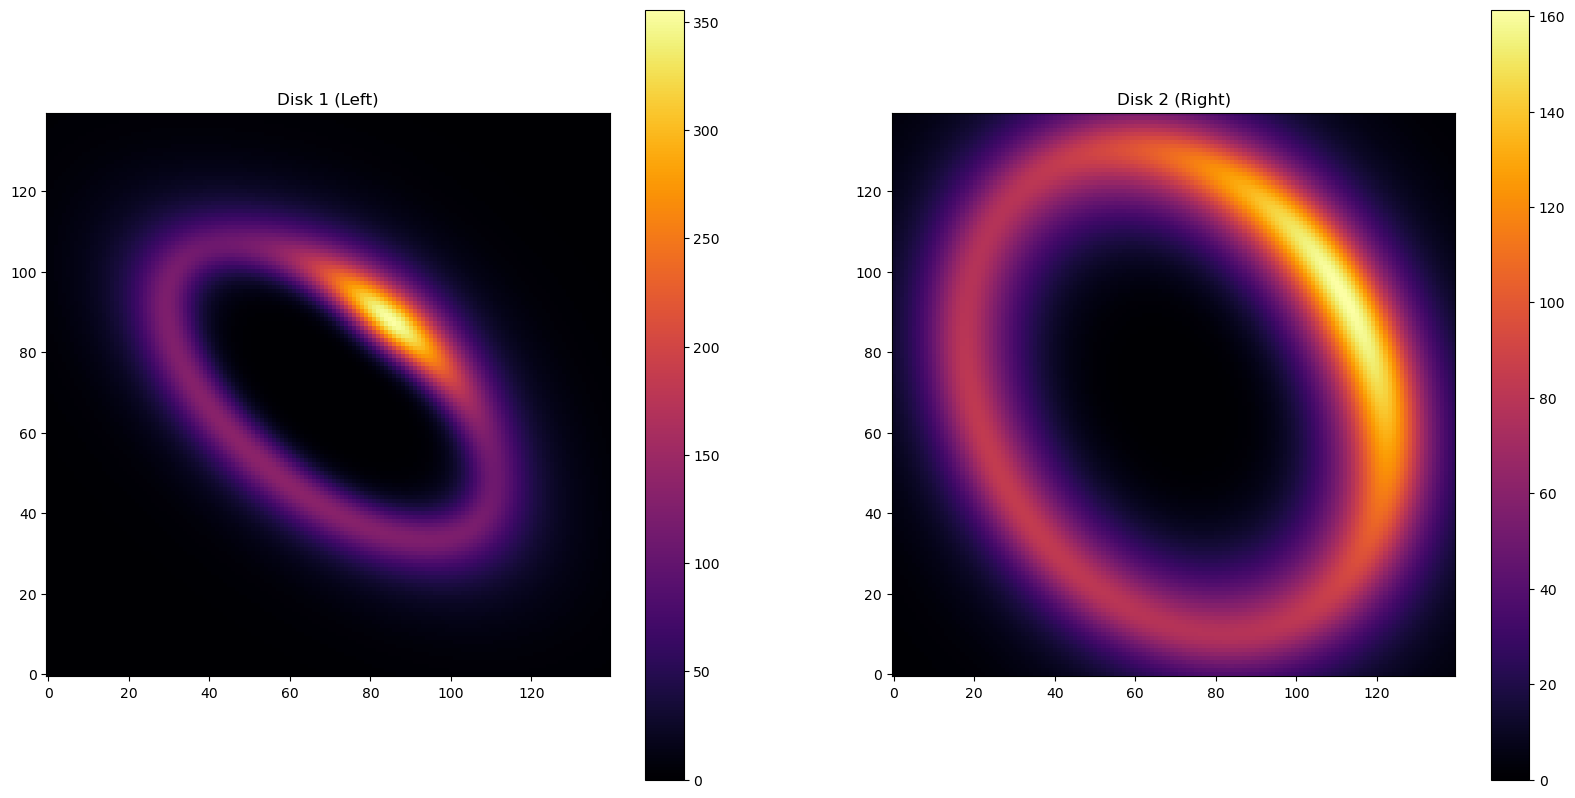

In [6]:
fig, axes = plt.subplots(1,2, figsize=(20,10))

im = axes[0].imshow(disk_image1, origin='lower', cmap='inferno')
axes[0].set_title("Disk 1 (Left)")
plt.colorbar(im,ax=axes[0])

im = axes[1].imshow(disk_image2, origin='lower', cmap='inferno')
axes[1].set_title("Disk 2 (Right)")
plt.colorbar(im,ax=axes[1])

## Timing Model Methods

In [7]:
def test():
    jax_model(DustEllipticalDistribution2PowerLaws, HenyeyGreenstein_SPF, disk_params=disk_params1,)

%timeit test

3.81 ns ± 0.00151 ns per loop (mean ± std. dev. of 7 runs, 100,000,000 loops each)


In [8]:
#def test():
#    jax_model(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_params=disk_params1,
#                              spf_params={'g1': 0.9, 'g2': -0.2, 'weight': 0.7})

#%timeit test

## Add Noise

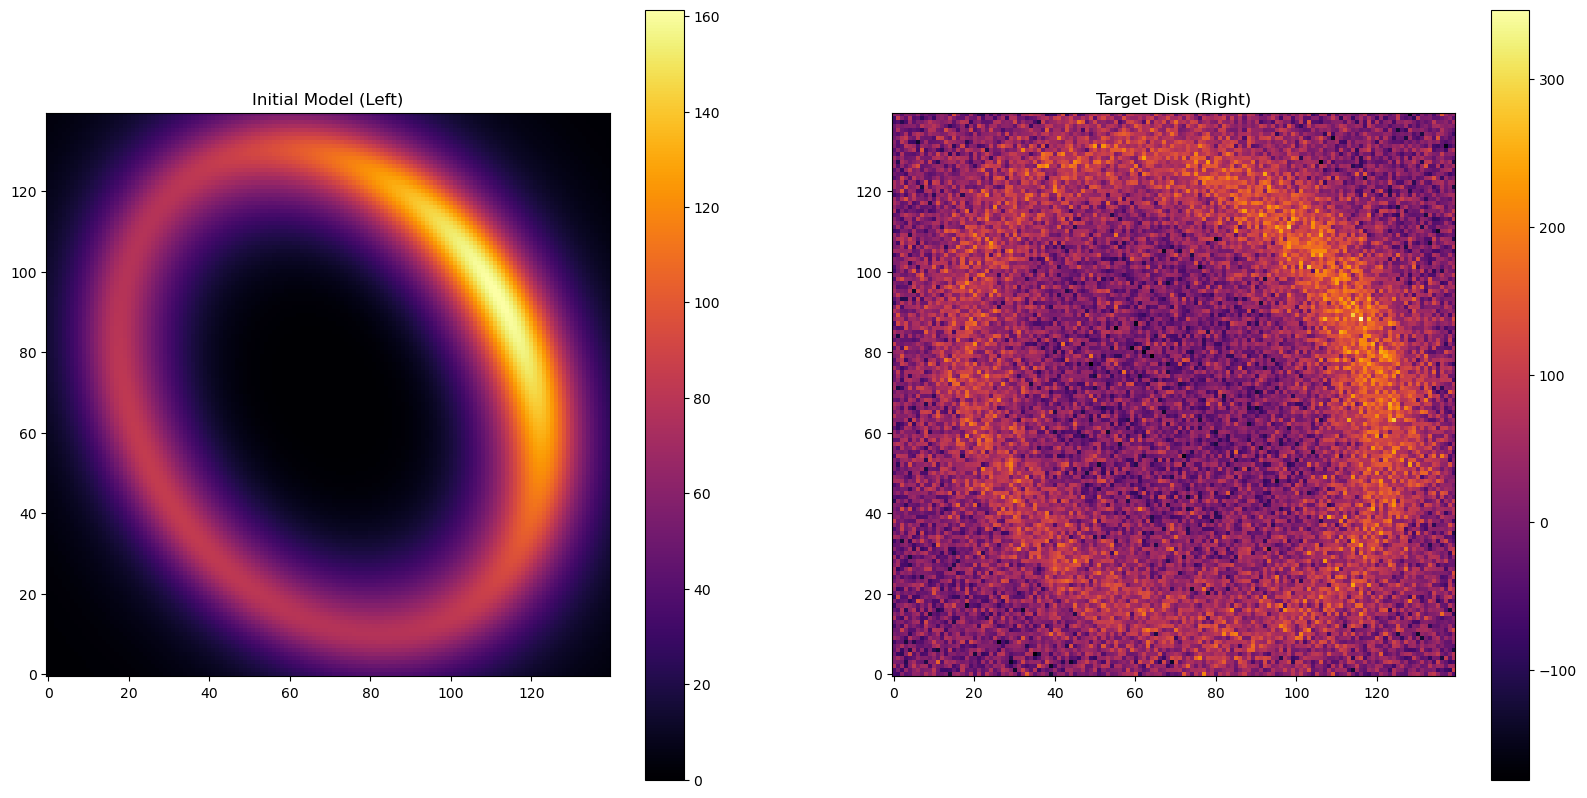

In [9]:
noise_level = 50
noise = np.random.normal(0, noise_level, disk_image1.shape)

fig, axes = plt.subplots(1,2, figsize=(20,10))

im = axes[0].imshow(disk_image2, origin='lower', cmap='inferno')
axes[0].set_title("Initial Model (Left)")
plt.colorbar(im,ax=axes[0])

im = axes[1].imshow(disk_image2+noise, origin='lower', cmap='inferno')
axes[1].set_title("Target Disk (Right)")
plt.colorbar(im,ax=axes[1])

## Testing Jax Grad with Disk Model Methods

In [10]:
#grad_func = jax.grad(jax_model_scal, argnums=(2, 3))
#print(grad_func(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_params2, spf_params))

## Log-Likelihood Testing

In [11]:
ll2 = log_likelihood(DustEllipticalDistribution2PowerLaws,DoubleHenyeyGreenstein_SPF,disk_params2,spf_params,disk_image2+noise,
           np.ones(disk_image2.shape)*noise_level)
ll1 = log_likelihood(DustEllipticalDistribution2PowerLaws,DoubleHenyeyGreenstein_SPF,disk_params1,spf_params,disk_image2+noise,
           np.ones(disk_image2.shape)*noise_level)

print("Likelihood of disk 2 model: {x}".format(x=ll2))
print("Likelihood of disk 1 model: {x}".format(x=ll1))

Likelihood of disk 2 model: -86584.765625
Likelihood of disk 1 model: -135013.109375


## Testing Jax Grad with Log-Likelihood Method

In [12]:
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_debug_nans", True)

ll_grad_func = jax.grad(log_likelihood, argnums=(2,3))
print(ll_grad_func(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_params1, spf_params, disk_image2+noise, np.ones(disk_image2.shape)*noise_level))

({'alpha_in': Array(2932.34608102, dtype=float64, weak_type=True), 'alpha_out': Array(-4331.77994041, dtype=float64, weak_type=True), 'flux_scaling': Array(-0.09150372, dtype=float64, weak_type=True), 'inclination': Array(-3602.87566486, dtype=float64, weak_type=True), 'position_angle': Array(83.84481327, dtype=float64, weak_type=True), 'sma': Array(4548.54847866, dtype=float64, weak_type=True)}, {'g1': Array(-32317.42729189, dtype=float64, weak_type=True), 'g2': Array(-5873.32431738, dtype=float64, weak_type=True), 'weight': Array(-49219.81895242, dtype=float64, weak_type=True)})


## Testing Scipy-Optimize Minimize with Log-Likelihood

In [13]:
import numpy as np

def convert_to_dict(disk_params, flux_scaling=1e6):
    disk_dict = {}
    disk_dict['inclination'] = disk_params[3]
    disk_dict['position_angle'] = disk_params[4]
    disk_dict['alpha_in'] = disk_params[0]
    disk_dict['alpha_out'] = disk_params[1]
    disk_dict['flux_scaling'] = flux_scaling
    disk_dict['sma'] = disk_params[2]
    return disk_dict

# using disk 1 params as initial parameters
disk_params_1d = np.array([disk_params1['alpha_in'], disk_params1['alpha_out'], disk_params1['sma'], disk_params1['inclination'],
                           disk_params1['position_angle']])

In [14]:
# comparing disk 1 model to the disk 2 noise model
print(-log_likelihood(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_params1, spf_params,
                    disk_image2+noise, jnp.ones(disk_image2.shape)*noise_level))

# comparing disk 2 model to the disk 2 noise model
print(-log_likelihood(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_params2, spf_params,
                    disk_image2+noise, jnp.ones(disk_image2.shape)*noise_level))

135013.08501160017
86584.77173006296


In [20]:
# JIT compiling likelihood-1d method

def test():
    jax_model(disk_params_1d, DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, spf_params,
                    disk_image2+noise, jnp.ones(disk_image2.shape)*noise_level)
%timeit test

3.81 ns ± 0.00198 ns per loop (mean ± std. dev. of 7 runs, 100,000,000 loops each)


### Optimizing Disk with Nelder-Mead Method (Doesn't Require Gradient)

In [26]:
from scipy.optimize import minimize

ll = lambda *args: -log_likelihood_1d(*args)
no_grad_method = "Nelder-Mead"

start = datetime.now()
soln = minimize(ll, disk_params_1d, args=(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, spf_params,
                                                     disk_params1['flux_scaling'], disk_image2+noise, jnp.ones(disk_image2.shape)*noise_level),
                                                     method = no_grad_method)
end = datetime.now()
print(end-start)

disk_fit_nm = convert_to_dict(soln.x)

0:00:01.061530


### Optimizing Disk with Gradient

In [27]:

ll = lambda *args: -log_likelihood_1d(*args)

start = datetime.now()
soln = minimize(ll, disk_params_1d, args=(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, spf_params,
                                                     disk_params1['flux_scaling'], disk_image2+noise, jnp.ones(disk_image2.shape)*noise_level),
                                                     method=None)
end = datetime.now()
print(end-start)

disk_fit_grad = convert_to_dict(soln.x)

0:00:00.816908


## Displaying Scipy Fit Model Results

In [28]:
# Lower Likelihood means better fit

print("Nelder-Mead Optimization Disk Parameters: " + str(disk_fit_nm))
print("Log-Likelihood: " + str(-log_likelihood(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_params2, spf_params,
                    disk_image2+noise, jnp.ones(disk_image2.shape)*noise_level)))
print("Gradient Optimization Disk Parameters: " + str(disk_fit_grad))
print("Log-Likelihood: " + str(-log_likelihood(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_params2, spf_params,
                    disk_image2+noise, jnp.ones(disk_image2.shape)*noise_level)))
print("Target Disk Parameters: " + str(disk_params2))

Nelder-Mead Optimization Disk Parameters: {'inclination': 39.609586751635554, 'position_angle': 29.85540572317588, 'alpha_in': 5.111552382955689, 'alpha_out': -6.787637636422179, 'flux_scaling': 1000000.0, 'sma': 39.69609220056656}
Log-Likelihood: 86584.77173006296
Gradient Optimization Disk Parameters: {'inclination': 39.60963445372628, 'position_angle': 29.85546164036117, 'alpha_in': 5.111521806104218, 'alpha_out': -6.787696477781536, 'flux_scaling': 1000000.0, 'sma': 39.696157524674156}
Log-Likelihood: 86584.77173006296
Target Disk Parameters: {'inclination': 40.0, 'position_angle': 30.0, 'alpha_in': 5.0, 'alpha_out': -7.0, 'flux_scaling': 1000000.0, 'sma': 40.0}


In [29]:
start = datetime.now()
disk_image_fit_nm = jax_model(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_params=disk_fit_nm,
                               spf_params={'g1': 0.5, 'g2': -0.3, 'weight': 0.7})
disk_image_fit_grad = jax_model(DustEllipticalDistribution2PowerLaws, DoubleHenyeyGreenstein_SPF, disk_params=disk_fit_grad,
                               spf_params={'g1': 0.5, 'g2': -0.3, 'weight': 0.7})
end = datetime.now()
print(end-start)

0:00:00.008521


Text(0.5, 1.0, 'Target Disk (Right)')

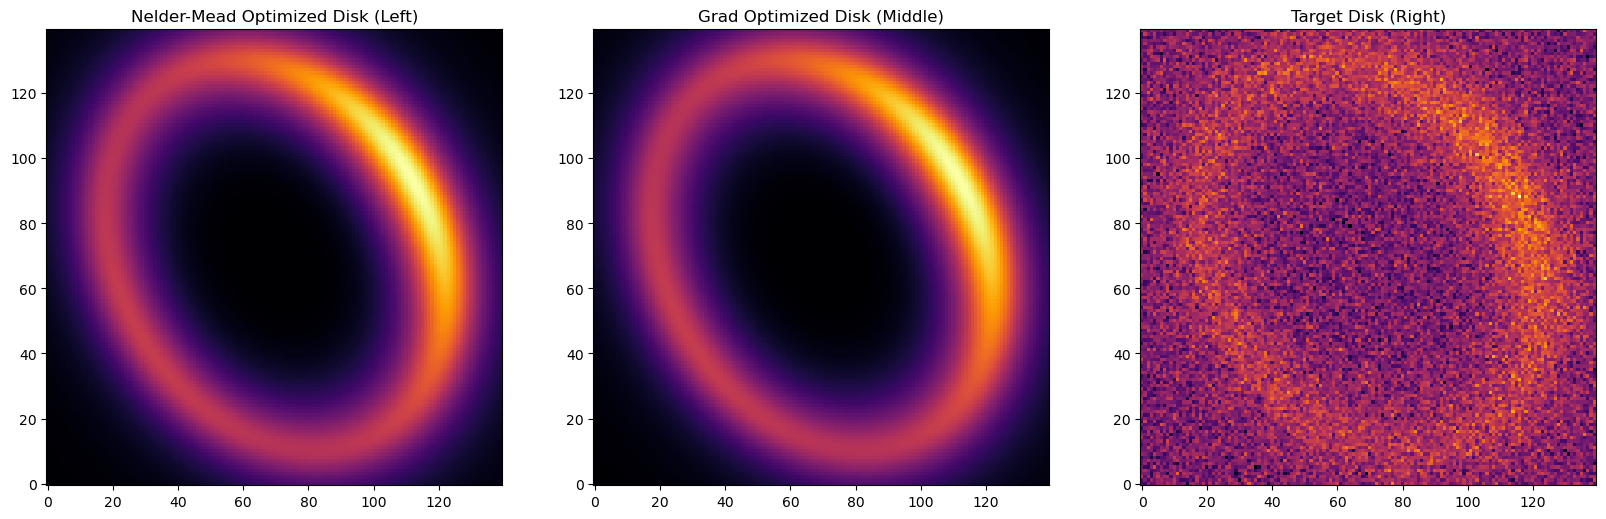

In [31]:
fig, axes = plt.subplots(1,3, figsize=(20,10))

axes[0].imshow(disk_image_fit_nm, origin='lower', cmap='inferno')
axes[0].set_title("Nelder-Mead Optimized Disk (Left)")

axes[1].imshow(disk_image_fit_grad, origin='lower', cmap='inferno')
axes[1].set_title("Grad Optimized Disk (Middle)")

axes[2].imshow(disk_image2+noise, origin='lower', cmap='inferno')
axes[2].set_title("Target Disk (Right)")